In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.preprocessing import StandardScaler
import ast

# Regresión

## Lectura de datos

In [2]:
df = pd.read_csv('./datasets/data_treino_dv_df_2000_2010.csv')
df.head(1)

,HORA (UTC),"VENTO, DIREï¿½ï¿½O HORARIA (gr) (ï¿½ (gr))","VENTO, VELOCIDADE HORARIA (m/s)",UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),TEMPERATURA Mï¿½XIMA NA HORA ANT. (AUT) (ï¿½C),TEMPERATURA Mï¿½NIMA NA HORA ANT. (AUT) (ï¿½C),"UMIDADE RELATIVA DO AR, HORARIA (%)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)","PRECIPITAï¿½ï¿½O TOTAL, HORï¿½RIO (mm)","VENTO, RAJADA MAXIMA (m/s)",PRESSï¿½O ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSï¿½O ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)
0,12:00,0.809017,1.8,69.0,60.0,22.6,20.7,61.0,888.2,0.0,3.8,888.2,887.7


In [3]:
df.columns = ['HORA','WIND_DIR_HOR','WIND_VEL_HOR','HUM_REL_MAX_ANT','HUM_REL_MIN_ANT','TEMP_MAX_ANT','TEMP_MIN_ANT','HUM_REL_HOR','PRES_ATM_NIV','PREC_HOR','RAFAGA_VIENTO','PRES_ATM_MAX_ANT','PRES_ATM_MIN_ANT']
df.head(2)

,HORA,WIND_DIR_HOR,WIND_VEL_HOR,HUM_REL_MAX_ANT,HUM_REL_MIN_ANT,TEMP_MAX_ANT,TEMP_MIN_ANT,HUM_REL_HOR,PRES_ATM_NIV,PREC_HOR,RAFAGA_VIENTO,PRES_ATM_MAX_ANT,PRES_ATM_MIN_ANT
0,12:00,0.809017,1.8,69.0,60.0,22.6,20.7,61.0,888.2,0.0,3.8,888.2,887.7
1,13:00,0.965926,2.7,62.0,55.0,24.2,22.5,55.0,888.4,0.0,4.7,888.4,888.2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87693 entries, 0 to 87692
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HORA              87693 non-null  object 
 1   WIND_DIR_HOR      87693 non-null  float64
 2   WIND_VEL_HOR      87693 non-null  float64
 3   HUM_REL_MAX_ANT   87693 non-null  float64
 4   HUM_REL_MIN_ANT   87693 non-null  float64
 5   TEMP_MAX_ANT      87693 non-null  float64
 6   TEMP_MIN_ANT      87693 non-null  float64
 7   HUM_REL_HOR       87693 non-null  float64
 8   PRES_ATM_NIV      87693 non-null  float64
 9   PREC_HOR          87693 non-null  float64
 10  RAFAGA_VIENTO     87693 non-null  float64
 11  PRES_ATM_MAX_ANT  87693 non-null  float64
 12  PRES_ATM_MIN_ANT  87693 non-null  float64
dtypes: float64(12), object(1)
memory usage: 8.7+ MB


In [5]:
df.isna().sum()

HORA                0
WIND_DIR_HOR        0
WIND_VEL_HOR        0
HUM_REL_MAX_ANT     0
HUM_REL_MIN_ANT     0
TEMP_MAX_ANT        0
TEMP_MIN_ANT        0
HUM_REL_HOR         0
PRES_ATM_NIV        0
PREC_HOR            0
RAFAGA_VIENTO       0
PRES_ATM_MAX_ANT    0
PRES_ATM_MIN_ANT    0
dtype: int64

In [6]:
df.drop(columns='HORA', inplace= True)

## Modelos con escalamiento de variables

Los siguientes modelos requieren escalamiento de las variables predictoras, por lo que se trabajan en la misma función

* KNeighboors (vecinos mas cercanos)
* Maquinas de soporte vectoriales

In [ ]:
def sliding_window_regression_models_scaling(
    df,
    target_col='WIND_VEL_HOR',
    T_values=[7, 14, 21],
    test_window=1,
    modelos=[
        {'name': 'Kneighboors', 'ModelClass': KNeighborsRegressor, 'params': {'n_neighbors': [5, 10,15], 'algorithm': ['ball_tree', 'kd_tree'], 'leaf_size':[30,60], 'n_jobs':[-1], 'weights': ['uniform', 'distance']}},
        {'name': 'SVR', 'ModelClass': SVR, 'params': {
          'C': [0.1, 1.0, 10],            # Regularización (más alto = menos tolerancia al error)
          'epsilon': [0.01, 0.1, 0.2],     # Margen de tolerancia al error sin penalización
          'kernel': ['rbf','linear'],          # Función de kernel (RBF = radial basis function, muy usada)
        }
      }
    ],
    save_path='./progreso'
):
    os.makedirs(save_path, exist_ok=True)
    resultados_por_T = {}



    for T in tqdm(T_values, desc="Procesando ventanas T", unit="ventana"):
        print(f"\n🧪 Ventana T = {T} días")
        T_hours = T * 24
        test_hours = test_window * 24
        total_windows = len(df) - T_hours - test_hours + 1
        print(f'😎 Total windows {total_windows}')

        output_path = os.path.join(save_path, f's_resultados_T{T}.csv')

        # Cargar resultados previos
        if os.path.exists(output_path):
            df_prev = pd.read_csv(output_path)
            if 'params' in df_prev:
                df_prev['params'] = df_prev['params'].apply(
                    lambda x: ast.literal_eval(x) if isinstance(x, str) else (None if pd.isna(x) else x)
                )
        else:
            df_prev = pd.DataFrame(columns=[
                'modelo', 'params', 'T_dias', 'T_horas', 'MAPE', 'MAE', 'RMSE', 'MSE', 'R2', 'LjungBox_p'
            ])

        # Precalcular splits
        splits = []
        for start in range(0,total_windows,24): #Para que la ventana se mueva cada 24 horas
            train = df.iloc[start: start + T_hours]
            test = df.iloc[start + T_hours: start + T_hours + test_hours]

            X_train = train.drop(columns=[target_col])
            y_train = train[target_col]
            X_test = test.drop(columns=[target_col])
            y_test = test[target_col]

            #Escalo variables
                #Instancio el escalador
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)


            splits.append((X_train, y_train, X_test, y_test))

        # Crear todos los modelos con combinaciones completas de parámetros
        models = []
        for modelo in modelos:
            model_name = modelo['name']
            ModelClass = modelo['ModelClass']
            param_grid = modelo['params']

            if param_grid is None:
                models.append({'name': model_name, 'model': ModelClass(), 'params': None})
            else:
                keys = list(param_grid.keys())
                values = list(param_grid.values())
                for combo in product(*values):
                    param_dict = dict(zip(keys, combo))
                    model_instance = ModelClass(**param_dict)
                    models.append({
                        'name': model_name,
                        'model': model_instance,
                        'params': param_dict
                    })

        # Evaluar cada modelo
        for m in models:
            ya_evaluado = ((df_prev['modelo'] == m['name']) & 
                           (df_prev['params'].apply(lambda p: p == m['params']))).any()

            if not df_prev.empty and ya_evaluado:
                print(f"✓ Modelo {m['name']} con {m['params']} ya evaluado para T={T}. Saltando...")
                continue

            resultados = {
                'modelo': m['name'],
                'params': m['params'],
                'T_dias': T,
                'T_horas': T_hours,
                'MAPE': [],
                'MAE': [],
                'RMSE': [],
                'MSE': [],
                'R2': [],
                'LjungBox_p': []
            }

            for X_train, y_train, X_test, y_test in tqdm(splits, desc=f"{m['name']} (T={T}d)", leave=False):
                model = m['model']
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                residuals = y_test.values - y_pred

                resultados['MAPE'].append(mean_absolute_percentage_error(y_test, y_pred))
                resultados['MAE'].append(mean_absolute_error(y_test, y_pred))
                resultados['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
                resultados['MSE'].append(mean_squared_error(y_test, y_pred))
                resultados['R2'].append(r2_score(y_test, y_pred))

                if len(residuals) >= 2:
                    ljung_p = acorr_ljungbox(residuals, lags=[1], return_df=True)['lb_pvalue'].iloc[0]
                else:
                    ljung_p = np.nan

                resultados['LjungBox_p'].append(ljung_p)

            #print(f"😶‍🌫️Numero de modelos realizado {len(resultados['MAPE'])}")
            # Guardar inmediatamente el resultado de este modelo
            nuevo_row = pd.DataFrame([{
                'modelo': resultados['modelo'],
                'params': resultados['params'],
                'T_dias': resultados['T_dias'],
                'T_horas': resultados['T_horas'],
                'MAPE': np.mean(resultados['MAPE']),
                'MAE': np.mean(resultados['MAE']),
                'RMSE': np.mean(resultados['RMSE']),
                'MSE': np.mean(resultados['MSE']),
                'R2': np.mean(resultados['R2']),
                'LjungBox_p': np.nanmean(resultados['LjungBox_p'])
            }])

            df_prev = pd.concat([df_prev, nuevo_row], ignore_index=True)
            df_prev.to_csv(output_path, index=False)
            print(f"📦 Guardado modelo {m['name']} con {m['params']} en T={T}")

        resultados_por_T[T] = df_prev
        print(f"✔ Resultados finales guardados en: {output_path}")

    return resultados_por_T


In [8]:
resultados_por_T = sliding_window_regression_models_scaling(df, target_col='WIND_VEL_HOR')

# Ver los DataFrames en memoria
df_w_7 = resultados_por_T[7]    # Para T=7 días
df_w_14 = resultados_por_T[14]    # Para T=7 días
df_w_21 = resultados_por_T[21]    # Para T=7 días


Procesando ventanas T:   0%|          | 0/3 [00:00<?, ?ventana/s]


🧪 Ventana T = 7 días
😎 Total windows 87502


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'ball_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'uniform'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'ball_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'distance'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'ball_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'uniform'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'ball_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'distance'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'kd_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'uniform'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'kd_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'distance'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'kd_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'uniform'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'kd_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'distance'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'ball_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'uniform'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'ball_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'distance'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'ball_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'uniform'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'ball_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'distance'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'kd_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'uniform'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'kd_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'distance'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'kd_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'uniform'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'kd_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'distance'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'ball_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'uniform'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'ball_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'distance'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'ball_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'uniform'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'ball_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'distance'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'kd_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'uniform'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'kd_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'distance'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'kd_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'uniform'} en T=7


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'kd_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'distance'} en T=7


📦 Guardado modelo SVR con {'C': 0.1, 'epsilon': 0.01, 'kernel': 'rbf'} en T=7


📦 Guardado modelo SVR con {'C': 0.1, 'epsilon': 0.01, 'kernel': 'linear'} en T=7


📦 Guardado modelo SVR con {'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'} en T=7


📦 Guardado modelo SVR con {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'} en T=7


📦 Guardado modelo SVR con {'C': 0.1, 'epsilon': 0.2, 'kernel': 'rbf'} en T=7


📦 Guardado modelo SVR con {'C': 0.1, 'epsilon': 0.2, 'kernel': 'linear'} en T=7


📦 Guardado modelo SVR con {'C': 1.0, 'epsilon': 0.01, 'kernel': 'rbf'} en T=7


📦 Guardado modelo SVR con {'C': 1.0, 'epsilon': 0.01, 'kernel': 'linear'} en T=7


📦 Guardado modelo SVR con {'C': 1.0, 'epsilon': 0.1, 'kernel': 'rbf'} en T=7


📦 Guardado modelo SVR con {'C': 1.0, 'epsilon': 0.1, 'kernel': 'linear'} en T=7


📦 Guardado modelo SVR con {'C': 1.0, 'epsilon': 0.2, 'kernel': 'rbf'} en T=7


📦 Guardado modelo SVR con {'C': 1.0, 'epsilon': 0.2, 'kernel': 'linear'} en T=7


📦 Guardado modelo SVR con {'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'} en T=7


📦 Guardado modelo SVR con {'C': 10, 'epsilon': 0.01, 'kernel': 'linear'} en T=7


📦 Guardado modelo SVR con {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'} en T=7


📦 Guardado modelo SVR con {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'} en T=7


📦 Guardado modelo SVR con {'C': 10, 'epsilon': 0.2, 'kernel': 'rbf'} en T=7


Procesando ventanas T:  33%|███▎      | 1/3 [46:20<1:32:41, 2780.54s/ventana]

📦 Guardado modelo SVR con {'C': 10, 'epsilon': 0.2, 'kernel': 'linear'} en T=7
✔ Resultados finales guardados en: ./progreso\s_resultados_T7.csv

🧪 Ventana T = 14 días
😎 Total windows 87334


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'ball_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'uniform'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'ball_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'distance'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'ball_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'uniform'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'ball_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'distance'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'kd_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'uniform'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'kd_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'distance'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'kd_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'uniform'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'kd_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'distance'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'ball_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'uniform'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'ball_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'distance'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'ball_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'uniform'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'ball_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'distance'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'kd_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'uniform'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'kd_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'distance'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'kd_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'uniform'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'kd_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'distance'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'ball_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'uniform'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'ball_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'distance'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'ball_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'uniform'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'ball_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'distance'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'kd_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'uniform'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'kd_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'distance'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'kd_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'uniform'} en T=14


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'kd_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'distance'} en T=14


📦 Guardado modelo SVR con {'C': 0.1, 'epsilon': 0.01, 'kernel': 'rbf'} en T=14


📦 Guardado modelo SVR con {'C': 0.1, 'epsilon': 0.01, 'kernel': 'linear'} en T=14


📦 Guardado modelo SVR con {'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'} en T=14


📦 Guardado modelo SVR con {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'} en T=14


📦 Guardado modelo SVR con {'C': 0.1, 'epsilon': 0.2, 'kernel': 'rbf'} en T=14


📦 Guardado modelo SVR con {'C': 0.1, 'epsilon': 0.2, 'kernel': 'linear'} en T=14


📦 Guardado modelo SVR con {'C': 1.0, 'epsilon': 0.01, 'kernel': 'rbf'} en T=14


📦 Guardado modelo SVR con {'C': 1.0, 'epsilon': 0.01, 'kernel': 'linear'} en T=14


📦 Guardado modelo SVR con {'C': 1.0, 'epsilon': 0.1, 'kernel': 'rbf'} en T=14


📦 Guardado modelo SVR con {'C': 1.0, 'epsilon': 0.1, 'kernel': 'linear'} en T=14


📦 Guardado modelo SVR con {'C': 1.0, 'epsilon': 0.2, 'kernel': 'rbf'} en T=14


📦 Guardado modelo SVR con {'C': 1.0, 'epsilon': 0.2, 'kernel': 'linear'} en T=14


📦 Guardado modelo SVR con {'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'} en T=14


📦 Guardado modelo SVR con {'C': 10, 'epsilon': 0.01, 'kernel': 'linear'} en T=14


📦 Guardado modelo SVR con {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'} en T=14


📦 Guardado modelo SVR con {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'} en T=14


📦 Guardado modelo SVR con {'C': 10, 'epsilon': 0.2, 'kernel': 'rbf'} en T=14


Procesando ventanas T:  67%|██████▋   | 2/3 [1:49:55<56:28, 3388.74s/ventana]

📦 Guardado modelo SVR con {'C': 10, 'epsilon': 0.2, 'kernel': 'linear'} en T=14
✔ Resultados finales guardados en: ./progreso\s_resultados_T14.csv

🧪 Ventana T = 21 días
😎 Total windows 87166


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'ball_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'uniform'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'ball_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'distance'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'ball_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'uniform'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'ball_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'distance'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'kd_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'uniform'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'kd_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'distance'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'kd_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'uniform'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 5, 'algorithm': 'kd_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'distance'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'ball_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'uniform'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'ball_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'distance'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'ball_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'uniform'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'ball_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'distance'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'kd_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'uniform'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'kd_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'distance'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'kd_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'uniform'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 10, 'algorithm': 'kd_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'distance'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'ball_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'uniform'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'ball_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'distance'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'ball_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'uniform'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'ball_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'distance'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'kd_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'uniform'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'kd_tree', 'leaf_size': 30, 'n_jobs': -1, 'weights': 'distance'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'kd_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'uniform'} en T=21


📦 Guardado modelo Kneighboors con {'n_neighbors': 15, 'algorithm': 'kd_tree', 'leaf_size': 60, 'n_jobs': -1, 'weights': 'distance'} en T=21


📦 Guardado modelo SVR con {'C': 0.1, 'epsilon': 0.01, 'kernel': 'rbf'} en T=21


📦 Guardado modelo SVR con {'C': 0.1, 'epsilon': 0.01, 'kernel': 'linear'} en T=21


📦 Guardado modelo SVR con {'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'} en T=21


📦 Guardado modelo SVR con {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'} en T=21


📦 Guardado modelo SVR con {'C': 0.1, 'epsilon': 0.2, 'kernel': 'rbf'} en T=21


📦 Guardado modelo SVR con {'C': 0.1, 'epsilon': 0.2, 'kernel': 'linear'} en T=21


📦 Guardado modelo SVR con {'C': 1.0, 'epsilon': 0.01, 'kernel': 'rbf'} en T=21


📦 Guardado modelo SVR con {'C': 1.0, 'epsilon': 0.01, 'kernel': 'linear'} en T=21


📦 Guardado modelo SVR con {'C': 1.0, 'epsilon': 0.1, 'kernel': 'rbf'} en T=21


📦 Guardado modelo SVR con {'C': 1.0, 'epsilon': 0.1, 'kernel': 'linear'} en T=21


📦 Guardado modelo SVR con {'C': 1.0, 'epsilon': 0.2, 'kernel': 'rbf'} en T=21


📦 Guardado modelo SVR con {'C': 1.0, 'epsilon': 0.2, 'kernel': 'linear'} en T=21


📦 Guardado modelo SVR con {'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'} en T=21


📦 Guardado modelo SVR con {'C': 10, 'epsilon': 0.01, 'kernel': 'linear'} en T=21


📦 Guardado modelo SVR con {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'} en T=21


📦 Guardado modelo SVR con {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'} en T=21


📦 Guardado modelo SVR con {'C': 10, 'epsilon': 0.2, 'kernel': 'rbf'} en T=21


Procesando ventanas T: 100%|██████████| 3/3 [3:12:41<00:00, 3853.81s/ventana]

📦 Guardado modelo SVR con {'C': 10, 'epsilon': 0.2, 'kernel': 'linear'} en T=21
✔ Resultados finales guardados en: ./progreso\s_resultados_T21.csv


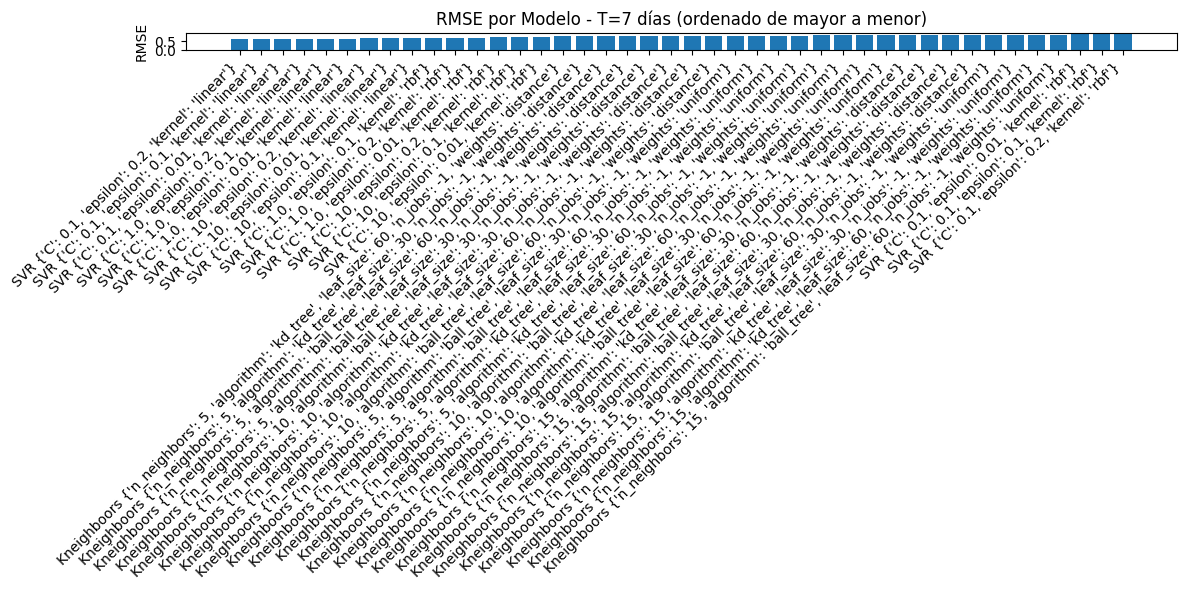

In [9]:
# Ordenar por RMSE de mayor a menor
df_w_7_sorted = df_w_7.sort_values(by="RMSE", ascending=True)

# Etiquetas combinadas modelo + params
etiquetas = df_w_7_sorted['modelo'].astype(str) + ' ' + df_w_7_sorted['params'].astype(str)

# Crear la gráfica
plt.figure(figsize=(12, 6))
plt.bar(etiquetas, df_w_7_sorted['RMSE'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE')
plt.title('RMSE por Modelo - T=7 días (ordenado de mayor a menor)')
plt.tight_layout()
plt.show()

## KNeighboors

Hay que normalizar datos por eso se hace por aparte

En principio, hay dos parámetros importantes en el clasificador KNeighbors: el número de vecinos y cómo se mide la distancia entre los puntos de datos. En la práctica, utilizar un número pequeño de vecinos, como tres o cinco, suele funcionar bien, pero se debería ajustar este parámetro.

La elección de la medida de distancia correcta es también crucial. Por defecto, KNeighbors utiliza la distancia euclidiana, que funciona bien en muchos casos. Uno de los puntos fuertes de 
-NN es que el modelo es muy fácil de entender, y a menudo da un rendimiento razonable sin necesidad de muchos ajustes. El uso de este algoritmo es un buen método de referencia para probar, antes de considerar técnicas más avanzadas.

La construcción del modelo de vecinos más cercanos suele ser muy rápida, pero cuando el conjunto de entrenamiento es muy grande (ya sea en número de características o en número de muestras) la predicción puede ser lenta. Cuando se utiliza el algoritmo 
-NN, es importante pre-procesar los datos, tema que revisaremos en secciones posteriores. Este enfoque no suele funcionar bien en conjuntos de datos con muchas características (cientos o más), y lo hace especialmente mal con conjuntos de datos en los que la mayoría de las características son 0 la mayor parte del tiempo (los llamados conjuntos de datos dispersos).

Por lo tanto, aunque el algoritmo de 
-vecinos más cercanos es fácil de entender, no se utiliza a menudo en la práctica, debido a que la predicción es lenta y a su incapacidad para manejar muchas características.

## Dudas para el profesor

1. El fit del escalador se debe realizar con los datos de train, y con ese trabajar tanto train como test? Como se hace en producción??